# Libraries

In [16]:
from kornia.color import rgb_to_linear_rgb, rgb_to_xyz, xyz_to_rgb, linear_rgb_to_rgb
import torchvision.datasets
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torch.nn.functional as F
import torchvision.models as models

# Helper functions

In [17]:
def rgb_to_lab(image: torch.Tensor) -> torch.Tensor:
    if not isinstance(image, torch.Tensor):
        raise TypeError(f"Input type is not a torch.Tensor. Got {type(image)}")

    if len(image.shape) < 3 or image.shape[-3] != 3:
        raise ValueError(f"Input size must have a shape of (*, 3, H, W). Got {image.shape}")

    # Convert from sRGB to Linear RGB
    lin_rgb = rgb_to_linear_rgb(image)

    xyz_im: torch.Tensor = rgb_to_xyz(lin_rgb)

    # normalize for D65 white point
    xyz_ref_white = torch.tensor([0.95047, 1.0, 1.08883], device=xyz_im.device, dtype=xyz_im.dtype)[..., :, None, None]
    xyz_normalized = torch.div(xyz_im, xyz_ref_white)

    threshold = 0.008856
    power = torch.pow(xyz_normalized.clamp(min=threshold), 1 / 3.0)
    scale = 7.787 * xyz_normalized + 4.0 / 29.0
    xyz_int = torch.where(xyz_normalized > threshold, power, scale)

    x: torch.Tensor = xyz_int[..., 0, :, :]
    y: torch.Tensor = xyz_int[..., 1, :, :]
    z: torch.Tensor = xyz_int[..., 2, :, :]

    L: torch.Tensor = (116.0 * y) - 16.0
    a: torch.Tensor = 500.0 * (x - y)
    _b: torch.Tensor = 200.0 * (y - z)

    out: torch.Tensor = torch.stack([L, a, _b], dim=-3)

    return out

In [18]:
def lab_to_rgb(L: torch.Tensor, a: torch.Tensor, _b: torch.Tensor, clip: bool = True) -> torch.Tensor:
    # if not isinstance(image, torch.Tensor):
    #     raise TypeError(f"Input type is not a torch.Tensor. Got {type(image)}")
    #
    # if len(image.shape) < 3 or image.shape[-3] != 3:
    #     raise ValueError(f"Input size must have a shape of (*, 3, H, W). Got {image.shape}")

    # L: torch.Tensor = image[..., 0, :, :]
    # a: torch.Tensor = image[..., 1, :, :]
    # _b: torch.Tensor = image[..., 2, :, :]

    fy = (L + 16.0) / 116.0
    fx = (a / 500.0) + fy
    fz = fy - (_b / 200.0)

    # if color data out of range: Z < 0
    fz = fz.clamp(min=0.0)

    fxyz = torch.stack([fx, fy, fz], dim=-3)

    # Convert from Lab to XYZ
    power = torch.pow(fxyz, 3.0)
    scale = (fxyz - 4.0 / 29.0) / 7.787
    xyz = torch.where(fxyz > 0.2068966, power, scale)

    # For D65 white point
    xyz_ref_white = torch.tensor([0.95047, 1.0, 1.08883], device=xyz.device, dtype=xyz.dtype)[..., :, None, None]
    xyz_im = xyz * xyz_ref_white

    rgbs_im: torch.Tensor = xyz_to_rgb(xyz_im)

    # https://github.com/richzhang/colorization-pytorch/blob/66a1cb2e5258f7c8f374f582acc8b1ef99c13c27/util/util.py#L107
    #     rgbs_im = torch.where(rgbs_im < 0, torch.zeros_like(rgbs_im), rgbs_im)

    # Convert from RGB Linear to sRGB
    rgb_im = linear_rgb_to_rgb(rgbs_im)

    # Clip to 0,1 https://www.w3.org/Graphics/Color/srgb
    if clip:
        rgb_im = torch.clamp(rgb_im, min=0.0, max=1.0)

    return rgb_im

In [19]:
class AverageMeter(object):
    '''A handy class from the PyTorch ImageNet tutorial'''

    def __init__(self):
        self.reset()

    def reset(self):
        self.val, self.avg, self.sum, self.count = 0, 0, 0, 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Size of photo

In [20]:
size = 32

# Device Configuration

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_path = 'images/test/'
test_transform = transforms.Compose([
    transforms.Resize((size, size)),  # can experiment
    transforms.ToTensor(),  # divide the pixel by 255
])

# Loading the data

In [22]:
test_dataset = torchvision.datasets.ImageFolder(root=test_path, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=350, shuffle=False)

# Convert RBG to LAB space

In [23]:
X = []  # array of tensors of  L
y = []  # array of tensors of A and B
X1 = []  # array of tensors of  L
y1 = []  # array of tensors of A and B
LAB1 = []
LAB = []
z = 0
for idx, (data, target) in enumerate(test_loader):
    for i in data:
#         print(z)
#         z = z + 1
        Lab = rgb_to_lab(i / (size-1))
        LAB1.append(Lab)
        X1.append(Lab[0])
        y1.append(Lab[1:3])
    LAB.append(LAB1)
    LAB1 = []
    X.append(X1)
    y.append(y1)
    X1 = []
    y1 = []

x = []
x1 = []
for batch in X:
    for i in batch:
        w = np.array(i)
        x1.append(torch.tensor(np.array([w])).unsqueeze(0))
#         print(torch.tensor(np.array([w])).shape)
    x.append(x1)
    x1 = []

print(len(x))
print(len(x[0]))
print(len(y))
print(len(y[0])) 

1
229
1
229


# Creating the model

In [24]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        resnet = models.resnet18(num_classes=365)
        # Change first conv layer to accept single-channel (grayscale) input
        resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1))
        # Extract midlevel features from ResNet-gray
        self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

        self.conv0 = nn.Conv2d(128, 1, 3, stride=1, padding=1)

        # The second model
        self.conv1 = nn.Conv2d(1, 64, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.t_conv1 = nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1)
        self.t_conv2 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)
        self.t_conv3 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)
        self.t_conv4 = nn.ConvTranspose2d(32, 2, 3, stride=1, padding=1)

    def forward(self, x):
        x00 = self.midlevel_resnet(x)
        x0 = self.conv0(x00)
        x1 = F.relu(self.conv1(x0))
        x1 = F.pad(x1, (14, 14, 14, 14), "constant", 0)
        x2 = F.relu(self.conv2(x1))
        x3 = F.relu(self.conv3(x2))
        x4 = F.relu(self.conv4(x3))
        x5 = self.t_conv1(x4)
        x6 = self.t_conv2(x5)
        x7 = self.t_conv3(x6)
        x8 = self.t_conv4(x7)
        x8 = torch.tanh(x8)
        return x8

# Initialize the network

In [25]:
model = CNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.2)
# optimizer = optimizer = optim.Adam(model.parameters())
loss_func = torch.nn.MSELoss()
# losses = AverageMeter()
losses = []

In [26]:
def load_model(checkpoint):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

In [27]:
load_model(torch.load("resnet.pth.tar"))

=> Loading checkpoint


In [28]:
def ACCURACY_OF_ONE(A, B, Predicted_A, Predicted_B):
    print("=> Calculating the accuracy of models")
    accuracy_A = []
    accuracy_B = []
    for i in range(len(A)):
#         print(min(B[i]), max(B[i]))
        for j in range(len(A[i])):
            diff_A = abs(A[i][j] - Predicted_A[i][j])
            accuracy_A_p = 100 * ((2 - diff_A) / 2)
            diff_B = abs(B[i][j] - Predicted_B[i][j])
            accuracy_B_p = 100 * ((2 - diff_B) / 2)
            accuracy_A.append(accuracy_A_p)
            accuracy_B.append(accuracy_B_p)
    return ((sum(accuracy_A)/len(accuracy_A)) + (sum(accuracy_B)/len(accuracy_B)))/2

In [29]:
def ACCURACY_OF_MODEL():
    allAcc = []
    for i in range(0, 229):
        scores = model(x[0][i])
        acc = ACCURACY_OF_ONE(LAB[0][i][1], LAB[0][i][2], scores[0][0], scores[0][1])
        allAcc.append(acc)
        print(acc)
    return sum(allAcc)/len(allAcc)

In [30]:
ACCURACY_OF_MODEL()

=> Calculating the accuracy of models
tensor(89.0708, grad_fn=<DivBackward0>)
=> Calculating the accuracy of models
tensor(81.7025, grad_fn=<DivBackward0>)
=> Calculating the accuracy of models
tensor(91.7824, grad_fn=<DivBackward0>)
=> Calculating the accuracy of models
tensor(65.9416, grad_fn=<DivBackward0>)
=> Calculating the accuracy of models
tensor(79.3999, grad_fn=<DivBackward0>)
=> Calculating the accuracy of models
tensor(94.4221, grad_fn=<DivBackward0>)
=> Calculating the accuracy of models
tensor(90.7209, grad_fn=<DivBackward0>)
=> Calculating the accuracy of models
tensor(86.0054, grad_fn=<DivBackward0>)
=> Calculating the accuracy of models
tensor(89.2489, grad_fn=<DivBackward0>)
=> Calculating the accuracy of models
tensor(91.4399, grad_fn=<DivBackward0>)
=> Calculating the accuracy of models
tensor(86.9787, grad_fn=<DivBackward0>)
=> Calculating the accuracy of models
tensor(91.0246, grad_fn=<DivBackward0>)
=> Calculating the accuracy of models
tensor(92.3346, grad_fn=<D

tensor(86.9326, grad_fn=<DivBackward0>)
=> Calculating the accuracy of models
tensor(90.1119, grad_fn=<DivBackward0>)
=> Calculating the accuracy of models
tensor(93.6134, grad_fn=<DivBackward0>)
=> Calculating the accuracy of models
tensor(92.0310, grad_fn=<DivBackward0>)
=> Calculating the accuracy of models
tensor(90.2985, grad_fn=<DivBackward0>)
=> Calculating the accuracy of models
tensor(78.1978, grad_fn=<DivBackward0>)
=> Calculating the accuracy of models
tensor(91.3680, grad_fn=<DivBackward0>)
=> Calculating the accuracy of models
tensor(87.0021, grad_fn=<DivBackward0>)
=> Calculating the accuracy of models
tensor(87.6024, grad_fn=<DivBackward0>)
=> Calculating the accuracy of models
tensor(83.1994, grad_fn=<DivBackward0>)
=> Calculating the accuracy of models
tensor(91.4586, grad_fn=<DivBackward0>)
=> Calculating the accuracy of models
tensor(94.0076, grad_fn=<DivBackward0>)
=> Calculating the accuracy of models
tensor(91.4629, grad_fn=<DivBackward0>)
=> Calculating the accur

tensor(85.4388, grad_fn=<DivBackward0>)
=> Calculating the accuracy of models
tensor(92.5437, grad_fn=<DivBackward0>)
=> Calculating the accuracy of models
tensor(97.0994, grad_fn=<DivBackward0>)
=> Calculating the accuracy of models
tensor(90.3473, grad_fn=<DivBackward0>)
=> Calculating the accuracy of models
tensor(88.0274, grad_fn=<DivBackward0>)
=> Calculating the accuracy of models
tensor(95.4393, grad_fn=<DivBackward0>)
=> Calculating the accuracy of models
tensor(94.9485, grad_fn=<DivBackward0>)
=> Calculating the accuracy of models
tensor(95.0450, grad_fn=<DivBackward0>)
=> Calculating the accuracy of models
tensor(91.0209, grad_fn=<DivBackward0>)
=> Calculating the accuracy of models
tensor(92.4410, grad_fn=<DivBackward0>)
=> Calculating the accuracy of models
tensor(95.2734, grad_fn=<DivBackward0>)
=> Calculating the accuracy of models
tensor(84.0821, grad_fn=<DivBackward0>)
=> Calculating the accuracy of models
tensor(92.3488, grad_fn=<DivBackward0>)
=> Calculating the accur

tensor(90.0960, grad_fn=<DivBackward0>)

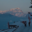

In [31]:
# Showing picture 10
output = lab_to_rgb(LAB[0][10][0]*(size-1), LAB[0][10][1]*(size-1), LAB[0][10][2]*(size-1))
transform = T.ToPILImage()
img = transform(output)
img

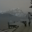

In [32]:
# Showing the prediction of picture 10
prediction = model(x[0][10])
output2 = lab_to_rgb(LAB[0][10][0]*(size-1), prediction[0][0]*(size-1), prediction[0][1]*(size-1))
transform = T.ToPILImage()
img2 = transform(output2)
img2